# Szum w Etykietach Danych

![label_noise_intro.png](https://live.staticflickr.com/65535/54328952408_f7e5bcb7c9_z.jpg)

*Obraz wygenerowany przy użyciu modelu generatywnego z OpenArt.ai.*

## Wstęp

Kluczowe w uczeniu maszynowym są dane. Od nich wszystko się zaczyna. W praktyce jednak dane często nie są idealne i zawierają pewien szum zmieniejszający ich jakość. Jednym z rodzajów takiego szumu jest szum w etykietach danych, co oznacza, że dla niektórych obserwacji etykiety są niepoprawne.

Przyczyny szumu w etykietach mogą być zróżnicowane. Często wynikają one z subiektywności oceny – różni eksperci mogą mieć odmienne zdanie, np. oceniając emocje na zdjęciach lub jakość wypracowania. Innym źródłem błędów może być zmęczenie anotatorów, które wpływa na ich koncentrację i dokładność.

Niejasności mogą też wynikać ze słabej jakości danych, która utrudnia jednoznaczną klasyfikację (np. rozmyte zdjęcie psa, który przypomina wilka). Czasem etykiety bywają generowane automatycznie przez modele sztucznej inteligencji, które również mogą popełniać błędy.

Warto wspomnieć o próbkach znajdujących się na granicy klas. Takie przypadki, np. w danych medycznych, gdzie objawy są zbliżone dla różnych chorób, również prowadzą do trudności w przypisaniu jednoznacznej etykiety.

Zaszumienie danych utrudnia wytrenowanie modelu o dobrej jakości, ponieważ model może skupić się bardziej na niepoprawnych informacjach niż na ogólnych regułach w nich zawartych.

## Zadanie

Twoim zadaniem będzie wytrenowanie **dwóch** sieci neuronowych do poprawnej binarnej klasyfikacji obrazów pomimo częściowego zaszumienia etykiet w danych treningowych. Zbiór treningowy jest niezbalansowany (weź to pod uwagę w swoim rozwiązaniu). Zbiór walidacyjny jak i testowy (który będzie użyty do ewaluacji Twojego finalnego rozwiązania) mają tylko poprawne etykiety (bez szumu).

**Architektura modeli jest zdefiniowana i nie możesz jej zmieniać.**

Zastanów się dlaczego korzystamy z dwóch modeli a nie jednego (to jest pewna zagadka) - to pomoże Ci zrozumieć zadanie i je rozwiązać.
Twoją rolą w tym zadaniu jest zaimplementować funkcję `your_selected_indices(targets, losses)`, która wybierze indeksy danych ze zbioru treningowego, które zostaną wykorzystane do trenowania modeli. Funkcja przyjmuje na wejściu tensor z etykietami danych (`targets`) i tensor z wartościami funkcji straty z obu modeli (`losses`). Wynikiem tej funkcji powininna być dwuelementowa lista, gdzie elementami będą tensory zawierające indeksy wybrane do trenowania modeli. Jeden model otrzymuje jeden zestaw indeksów, drugi model otrzymuje drugi.
Poniżej w notatniku znajdziesz komórkę, w której znajduje się miejsce na Twoją funkcję. Komórka, którą powinieneś zmodyfikować jest wyraźnie oznaczona. Żeby lepiej zrozumieć jej działanie i cel warto zobaczyć kontekst i miejsce gdzie ta funkcja zostanie wywołana w pętli treningowej.

### Kryterium Oceny
Ostateczna ocena zadania będzie na podstawie średniej wartości zbalansowanej miary trafności (*ang. balanced accuracy, BAC*) z dwóch modeli tj. ${BAC}_{mean} = \frac{BAC_1+BAC_2}{2}$ gdzie $BAC_i$ to *balanced accuracy* dla modelu $i$, ($i = 1, 2$).

Za to zadanie możesz zdobyć pomiędzy 0 a 100 punktów.

Twój finalny wynik punktowy za rozwiązanie zadania obliczony będzie według poniższej funkcji (im wyższa wartość tym lepiej) przy dodatkowym zastosowaniu zakrąglenia do wartości całkowitych:
$$
\mathrm{Punkty} =
\begin{cases}
    0 & \text{jeżeli } {BAC}_{mean} \leq 0.5 \\
    100 \times \frac{{BAC}_{mean} - 0.5}{0.8 - 0.5} & \text{jeżeli } 0.5 < {BAC}_{mean} < 0.8 \\
    100 & \text{jeżeli } {BAC}_{mean} \geq 0.8
\end{cases}
$$

**Uwaga: Zauważ, że żeby zdobyć maksymalną ilość punktów nie ma konieczności osiągnięcia maksymalnej wartości *balanced accuracy* równej 1. Jeśli ${BAC}_{mean}$ będzie równe co najmniej 0.8, wówczas otrzymasz maksymalną liczbę punktów.**

To kryterium i wszystkie funkcje, o których mowa powyżej, są zaimplementowane poniżej przez nas.

## Ograniczenia

- Twoje rozwiazanie będzie testowane na Platformie Konkursowej bez dostępu do internetu oraz w środowisku z GPU.
- Ewaluacja Twojego finalnego rozwiązania na Platformie Konkursowej nie może trwać dłużej niż 5 minut z GPU.
- **Nie możesz** zmieniać architektury modeli - musi to być zdefiniowany przez nas `SmallMobileNet`.

## Pliki zgłoszeniowe
Ten notebook uzupełniony o Twoje rozwiązanie (patrz funkcja `your_selected_indices`).

## Ewaluacja
Pamiętaj, że podczas sprawdzania flaga `FINAL_EVALUATION_MODE` zostanie ustawiona na `True`.

Za to zadanie możesz zdobyć pomiędzy 0 a 100 punktów. Liczba punktów, którą zdobędziesz, będzie wyliczona na (tajnym) zbiorze testowym na Platformie Konkursowej na podstawie wyżej wspomnianego wzoru, zaokrąglona do liczby całkowitej. Jeśli Twoje rozwiązanie nie będzie spełniało powyższych kryteriów lub nie będzie wykonywać się prawidłowo, otrzymasz za zadanie 0 punktów.

# Kod Startowy
W tej sekcji inicjalizujemy środowisko poprzez zaimportowanie potrzebnych bibliotek i funkcji. Przygotowany kod ułatwi Tobie efektywne operowanie na danych i budowanie właściwego rozwiązania.

In [1]:
# W czasie sprawdzania Twojego rozwiązania, wartość flagi FINAL_EVALUATION_MODE zostanie zmieniona na True
FINAL_EVALUATION_MODE = False

In [2]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
import os
from tqdm import tqdm
from typing import Optional, Tuple, List

import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
from torchvision.datasets.folder import VisionDataset

from sklearn.metrics import balanced_accuracy_score

## Funkcje i Stałe Pomocnicze

In [3]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
SEED = 123
IMAGES_DIR = "data"
TASK_DATASET_LABELS_FILE = "dataset_labels.csv"

ROOT_DIR = os.getcwd()
TRAIN_DATASET_PATH = os.path.join(ROOT_DIR,'train')
VAL_DATASET_PATH = os.path.join(ROOT_DIR, 'val')

TRAIN_DATASET_URL = "1qmNNmDv-wUcAv5mvO6vYJV3mQ2SNIGnI"
VAL_DATASET_URL = "1YUJYD12NmKRSzFJGMrX-a61d6mnTaWbG"

In [4]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-2
NUM_EPOCHS = 6
NUM_CLASSES = 2
BATCH_SIZE = 128
WEIGHT_DECAY = 1e-3

if not FINAL_EVALUATION_MODE:
  print(f"Using {DEVICE} device")

Using cuda device


In [5]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
def seed_everything(seed: int) -> None:
    """
    Ustawia ziarno (seed) dla odtwarzalności wyników w Pythonie, NumPy oraz PyTorch.

    Funkcja ustawia ziarno dla generatorów liczb losowych Pythonie, NumPy oraz PyTorch,
    a także konfiguruje PyTorch do pracy w trybie deterministycznym.

    Parametry:
        seed (int): Wartość ziarna do ustawienia.
    """
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Ładowanie Danych
Za pomocą poniższego kodu dane zostaną wczytane i odpowiednio przygotowane.

In [6]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
def download_data(dataset_path, dataset_url):
    """Pobiera zbiór danych z Google Drive Olimpiady i zapisuje go w folderze."""
    import gdown
    import shutil

    # Utwórz lub zresetuj folder
    output = dataset_path+".zip"
    if os.path.exists(dataset_path):
        shutil.rmtree(dataset_path)
    if os.path.exists(output):
        os.remove(output)

    url = f'https://drive.google.com/uc?id={dataset_url}'
    gdown.download(url, output, fuzzy=True)

    print(f"Downloaded: {output}")

# Pobierz dane tylko jeśli nie jesteś w trybie FINAL_EVALUATION_MODE
if not FINAL_EVALUATION_MODE:
    download_data(TRAIN_DATASET_PATH, TRAIN_DATASET_URL)
    download_data(VAL_DATASET_PATH, VAL_DATASET_URL)

Downloading...
From (original): https://drive.google.com/uc?id=1qmNNmDv-wUcAv5mvO6vYJV3mQ2SNIGnI
From (redirected): https://drive.google.com/uc?id=1qmNNmDv-wUcAv5mvO6vYJV3mQ2SNIGnI&confirm=t&uuid=09c40cc3-7fb6-44ac-98be-43281875c24b
To: c:\Users\Bart_local\Documents\Repos\II-OlimpiadaAI_priv\1_etap\4_szum_w_etykietach_danych\train.zip
100%|██████████| 11.9M/11.9M [00:00<00:00, 34.9MB/s]


Downloaded: c:\Users\Bart_local\Documents\Repos\II-OlimpiadaAI_priv\1_etap\4_szum_w_etykietach_danych\train.zip


Downloading...
From: https://drive.google.com/uc?id=1YUJYD12NmKRSzFJGMrX-a61d6mnTaWbG
To: c:\Users\Bart_local\Documents\Repos\II-OlimpiadaAI_priv\1_etap\4_szum_w_etykietach_danych\val.zip
100%|██████████| 1.19M/1.19M [00:00<00:00, 10.7MB/s]

Downloaded: c:\Users\Bart_local\Documents\Repos\II-OlimpiadaAI_priv\1_etap\4_szum_w_etykietach_danych\val.zip


In [7]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

# Klasa zbioru danych
class TaskDataset(VisionDataset):
    def __init__(
        self,
        root: str,
        transform: Optional[callable] = None,
    ):
        super().__init__(
            root,
            transform=transform,
        )
        self.root = root

        if not self._check_integrity():
            raise RuntimeError(
                f"Nie znaleziono zbioru danych. Sprawdź czy ścieżka {self.root} istnieje. Powinna ona zwierać folder '{IMAGES_DIR}' i plik '{TASK_DATASET_LABELS_FILE}' file"
            )
        self.labels_df = self._read_labels_from_file()
        self.labels_header = 'label'

    def _read_labels_from_file(self) -> pd.DataFrame:
        df = pd.read_csv(os.path.join(self.root, TASK_DATASET_LABELS_FILE))
        return df

    def _check_integrity(self) -> bool:
        return os.path.exists(os.path.join(self.root, IMAGES_DIR)) and os.path.exists(
            os.path.join(self.root, TASK_DATASET_LABELS_FILE)
        )

    def __len__(self) -> int:
        return len(self.labels_df)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, np.ndarray]:
        img = self._load_image(idx)
        label = self._load_label(idx)
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def _load_image(self, idx: int) -> Image.Image:
        img_path = os.path.join(
            self.root, IMAGES_DIR, self.labels_df.iloc[idx]['file_name']
        )
        img = Image.open(img_path)
        return img

    def _load_label(self, idx: int):
        label = self.labels_df.iloc[idx][self.labels_header]
        return np.array([int(label)])

In [8]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
def unpack_data(unpack_path, dataset_name) -> None:
    dataset_zip_path = os.path.join(ROOT_DIR, dataset_name+".zip")
    dataset_local_dir = os.path.join(unpack_path, dataset_name)
    if not os.path.exists(dataset_local_dir):
        if not os.path.exists(dataset_zip_path):
            raise FileNotFoundError(
                f"Nie znaleziono pliku {dataset_zip_path} w bieżącym folderze."
            )

        with zipfile.ZipFile(dataset_zip_path, "r") as zip_ref:
            zip_ref.extractall(unpack_path)

In [9]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
# Funkcja ładująca dane treningowe i walidacyjne
def load_data() -> Tuple[DataLoader, DataLoader]:
    """
    Funkcja ładująca dane treningowe i walidacyjne przy użyciu klasy TaskDataset.

    Funkcja tworzy zbiory danych dla danych treningowych oraz walidacyjnych,
    stosuje podstawową transformację (konwersję do tensora), a następnie
    opakowuje je w obiekty DataLoader.

    Zwraca:
        Tuple[DataLoader, DataLoader]: Obiekty DataLoader dla zbioru treningowego oraz walidacyjnego.
    """
    base_transform = transforms.Compose([transforms.ToTensor()])

    train_dataset = TaskDataset(root=TRAIN_DATASET_PATH, transform=base_transform)
    val_dataset = TaskDataset(root=VAL_DATASET_PATH, transform=base_transform)

    train_loader = DataLoader(
        dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False
    )
    val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader

In [10]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
# Rozpakujmy i załadujmy dane
if not FINAL_EVALUATION_MODE:
    unpack_data(ROOT_DIR, "train")
    unpack_data(ROOT_DIR, "val")
    train_loader, val_loader = load_data()

## Architektura Modelu

In [11]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
class SmallMobileNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(SmallMobileNet, self).__init__()

        # Główne bloki konwolucyjne
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True),
            nn.Conv2d(
                32, 32, kernel_size=3, stride=1, padding=1, groups=32, bias=False
            ),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True),
            nn.Conv2d(32, 64, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU6(inplace=True),
            nn.Conv2d(
                64, 64, kernel_size=3, stride=2, padding=1, groups=64, bias=False
            ),
            nn.BatchNorm2d(64),
            nn.ReLU6(inplace=True),
            nn.Conv2d(64, 128, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU6(inplace=True),
            nn.Conv2d(
                128, 128, kernel_size=3, stride=2, padding=1, groups=128, bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU6(inplace=True),
            nn.Conv2d(128, 256, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU6(inplace=True),
        )

        self.pool = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU6(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## Kod z Kryterium Oceniającym

Kod, zbliżony do poniższego, będzie używany do oceny rozwiązania na zbiorze testowym.

In [12]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
def predict_and_evaluate(model, val_loader, device, verbose=False):
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    balanced_accuracy = balanced_accuracy_score(all_targets, all_preds)

    if verbose:
        print(f"Balanced Accuracy: {balanced_accuracy}")

    return balanced_accuracy

In [13]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
def performance(bac_1: float, bac_2: float) -> None:
    """
    Oblicza i wypisuje wynik wydajności na podstawie dwóch wartości balanced accuracy.

    Ostateczny wynik to średnia z obu wartości, przeskalowana między ustalonymi granicami,
    co przekłada się na liczbę zdobytych punktów.

    Parametry:
        bac_1 (float): Wartość balanced accuracy dla pierwszego modelu.
        bac_2 (float): Wartość balanced accuracy dla drugiego modelu.
    """
    bac_mean = (bac_1 + bac_2) / 2
    if bac_mean <= 0.5:
        points = 0
    elif 0.5 < bac_mean < 0.8:
        points = (bac_mean - 0.5) / (0.8 - 0.5) * 100
        points = int(round(points))
    else:
        points = 100

    print(
        f"Twoje rozwiązanie ma średnią wartość balanced accuracy równą {round(bac_mean, 5)} na zbiorze walidacyjnym, co daje {points}/100 punktów."
    )
    return points

## Trening Modelu

In [14]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################


# Funkcja do trenowania modelu
def train(
    model1,
    model2,
    optimizer1,
    optimizer2,
    criterion,
    train_loader,
    val_loader,
    num_epochs,
    device,
    select_indices_fn,
):

    verbose = False if FINAL_EVALUATION_MODE else True

    # Historia metryk dla każdego modelu
    metrics = {
        k: [[], []]
        for k in [
            "train_loss",
            "val_loss",
            "train_bac",
            "val_bac",
        ]
    }
    epochs_range = np.arange(num_epochs) + 1

    # Główna pętla treningowa
    for epoch in epochs_range:
        print(f"Epoch {epoch}")

        # Historia statystyk dla każdego modelu
        stats = {
            k: [0, 0] for k in ["train_loss", "train_total", "val_loss", "val_total"]
        }
        preds_targets = {
            k: [[], []]
            for k in ["train_preds", "train_targets", "val_preds", "val_targets"]
        }

        model1.train(), model2.train()
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}"):
            inputs, targets = inputs.to(device), targets.squeeze().long().to(device)

            outputs = [m(inputs) for m in (model1, model2)]
            losses = [criterion(out, targets) for out in outputs]

            # --- GŁÓWNY PUNKT ZADANIA ---
            selected_indices = select_indices_fn(targets, losses)
            # ---------------------------

            # Propagacja wsteczna dla każdego modelu
            for i, (model, optim) in enumerate(
                [(model1, optimizer1), (model2, optimizer2)]
            ):
                optim.zero_grad()
                sel_idx = selected_indices[i]
                loss = criterion(model(inputs[sel_idx]), targets[sel_idx]).mean()

                loss.backward()
                optim.step()

                # Historia statystyk
                stats["train_loss"][i] += loss.item() * len(sel_idx)
                stats["train_total"][i] += len(sel_idx)
                preds = outputs[i].max(1)[1]
                preds_targets["train_preds"][i].extend(preds[sel_idx].cpu().numpy())
                preds_targets["train_targets"][i].extend(targets[sel_idx].cpu().numpy())

        # Ewaluacja na zbiorze walidacyjnym
        if verbose:
            model1.eval(), model2.eval()
            with torch.no_grad():
                for inputs, targets in tqdm(
                    val_loader, desc=f"Validation {epoch}/{num_epochs}"
                ):
                    inputs, targets = inputs.to(device), targets.squeeze().long().to(
                        device
                    )

                    for i, model in enumerate([model1, model2]):
                        outputs = model(inputs)
                        loss = criterion(outputs, targets).mean()
                        preds = outputs.max(1)[1]

                        stats["val_loss"][i] += loss.item() * inputs.size(0)
                        stats["val_total"][i] += inputs.size(0)
                        preds = outputs.max(1)[1]
                        preds_targets["val_preds"][i].extend(preds.cpu().numpy())
                        preds_targets["val_targets"][i].extend(targets.cpu().numpy())

        # Obliczanie metryk
        if verbose:
            models = [model1, model2]
            for i in range(2):
                for phase in ["train", "val"]:
                    preds = preds_targets[f"{phase}_preds"][i]
                    targets = preds_targets[f"{phase}_targets"][i]

                    metrics[f"{phase}_loss"][i].append(
                        stats[f"{phase}_loss"][i] / stats[f"{phase}_total"][i]
                    )
                    metrics[f"{phase}_bac"][i].append(
                        balanced_accuracy_score(targets, preds)
                    )

                print(
                    f"Model{i+1} - Train Loss: {metrics['train_loss'][i][-1]:.4f}, "
                    f"Train balanced accuracy: {metrics['train_bac'][i][-1]:.4f} --- "
                    f"Validation Loss: {metrics['val_loss'][i][-1]:.4f}, "
                    f"Validation balanced accuracy: {metrics['val_bac'][i][-1]:.4f}, "
                )

    # Generowanie wykresów
    if verbose:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        colors = ["#fa2729", "#ac1a1c", "#1a6aff", "#144aad"]
        linestyles = ["-", "--"]

        for i, model_name in enumerate(["Model1", "Model2"]):
            for j, phase in enumerate(["train", "val"]):

                color = colors[i * 2 + j]
                ax1.plot(
                    epochs_range,
                    metrics[f"{phase}_loss"][i],
                    color=color,
                    marker="o",
                    linestyle=linestyles[j],
                    label=f"{model_name} {phase.title()} Loss",
                )
                ax2.plot(
                    epochs_range,
                    metrics[f"{phase}_bac"][i],
                    color=color,
                    marker="o",
                    linestyle=linestyles[j],
                    label=f"{model_name} {phase.title()} balanced accuracy",
                )

        for ax, title in zip([ax1, ax2], ["Loss", "Balanced accuracy"]):
            ax.set_title(f"Training and Validation {title}")
            ax.set_xticks(epochs_range)
            ax.set_xlabel("Epochs")
            ax.set_ylabel(title)
            ax.legend()

        plt.tight_layout()
        plt.show()

## Przykładowe Rozwiązanie
Poniżej przedstawiamy uproszczone rozwiązanie, które służy jako przykład demonstrujący podstawową funkcjonalność notatnika. Może ono posłużyć jako punkt wyjścia do opracowania Twojego rozwiązania.

In [15]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
def default_select_indices(targets, losses):
    # Wszystkie indeksy dla obu modeli
    selected_indices = [torch.arange(targets.shape[0]).to(DEVICE) for _ in range(2)]
    return selected_indices

Epoch 1


Validation 1/6: 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


Model1 - Train Loss: 0.6430, Train balanced accuracy: 0.4991 --- Validation Loss: 0.7081, Validation balanced accuracy: 0.5000, 
Model2 - Train Loss: 0.6380, Train balanced accuracy: 0.5026 --- Validation Loss: 0.7231, Validation balanced accuracy: 0.5000, 
Epoch 2


Validation 2/6: 100%|██████████| 8/8 [00:00<00:00, 19.86it/s]


Model1 - Train Loss: 0.5983, Train balanced accuracy: 0.5000 --- Validation Loss: 0.7850, Validation balanced accuracy: 0.5000, 
Model2 - Train Loss: 0.5942, Train balanced accuracy: 0.5125 --- Validation Loss: 0.9544, Validation balanced accuracy: 0.5000, 
Epoch 3


Validation 3/6: 100%|██████████| 8/8 [00:00<00:00, 20.58it/s]


Model1 - Train Loss: 0.5892, Train balanced accuracy: 0.5054 --- Validation Loss: 1.6330, Validation balanced accuracy: 0.5000, 
Model2 - Train Loss: 0.5781, Train balanced accuracy: 0.5000 --- Validation Loss: 0.6435, Validation balanced accuracy: 0.5000, 
Epoch 4


Validation 4/6: 100%|██████████| 8/8 [00:00<00:00, 20.23it/s]


Model1 - Train Loss: 0.5782, Train balanced accuracy: 0.5000 --- Validation Loss: 1.3838, Validation balanced accuracy: 0.5000, 
Model2 - Train Loss: 0.5690, Train balanced accuracy: 0.5000 --- Validation Loss: 0.7031, Validation balanced accuracy: 0.5000, 
Epoch 5


Validation 5/6: 100%|██████████| 8/8 [00:00<00:00, 19.87it/s]


Model1 - Train Loss: 0.5683, Train balanced accuracy: 0.5000 --- Validation Loss: 1.3149, Validation balanced accuracy: 0.5000, 
Model2 - Train Loss: 0.5690, Train balanced accuracy: 0.5135 --- Validation Loss: 0.6303, Validation balanced accuracy: 0.5000, 
Epoch 6


Validation 6/6: 100%|██████████| 8/8 [00:00<00:00, 20.57it/s]


Model1 - Train Loss: 0.5682, Train balanced accuracy: 0.5202 --- Validation Loss: 0.8440, Validation balanced accuracy: 0.5000, 
Model2 - Train Loss: 0.5624, Train balanced accuracy: 0.5000 --- Validation Loss: 0.7563, Validation balanced accuracy: 0.5000, 


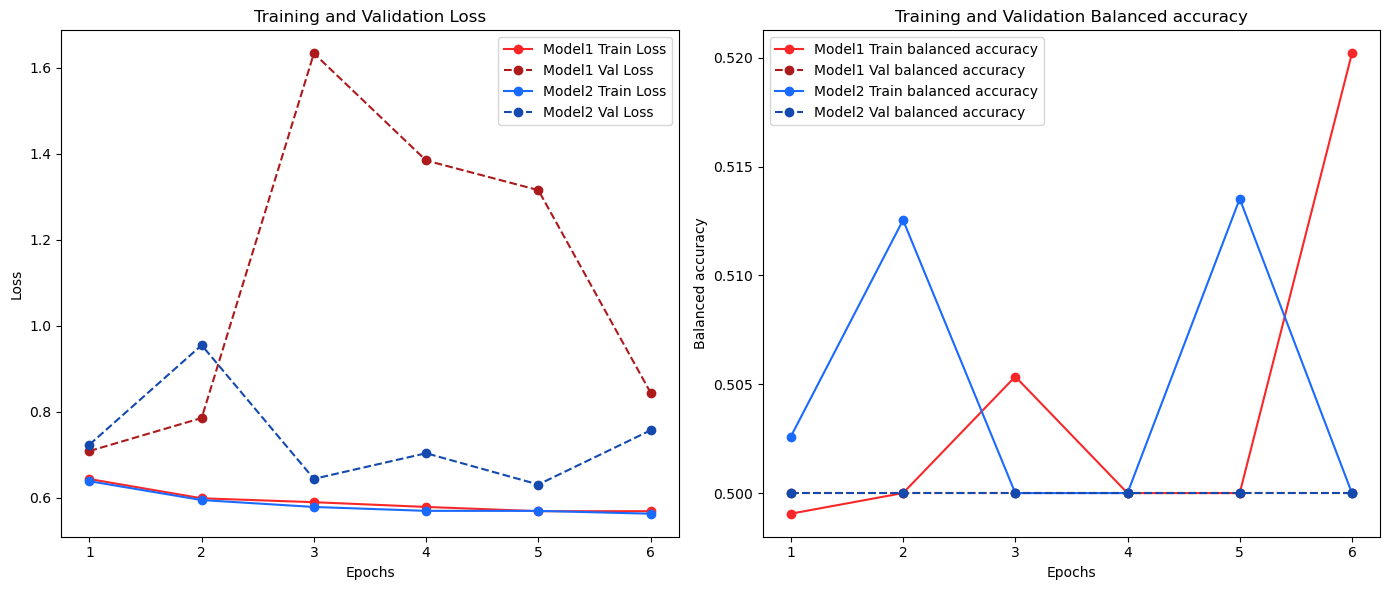

Balanced Accuracy: 0.5
Balanced Accuracy: 0.5
Twoje rozwiązanie ma średnią wartość balanced accuracy równą 0.5 na zbiorze walidacyjnym, co daje 0/100 punktów.


In [16]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
# WAŻNE: Trenujemy zawsze dwa modele i ewaluujemy

if not FINAL_EVALUATION_MODE:
    seed_everything(SEED)
    criterion = nn.CrossEntropyLoss(reduction="none")

    model1 = SmallMobileNet(NUM_CLASSES).to(DEVICE)
    model2 = SmallMobileNet(NUM_CLASSES).to(DEVICE)

    optimizer1 = AdamW(model1.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    optimizer2 = AdamW(model2.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    seed_everything(SEED)
    train(
        model1,
        model2,
        optimizer1,
        optimizer2,
        criterion,
        train_loader,
        val_loader,
        NUM_EPOCHS,
        DEVICE,
        select_indices_fn=default_select_indices,
    )

    # Ewaluacja przykładowego rozwiązania
    bac_1 = predict_and_evaluate(model1, val_loader, DEVICE, verbose=True)
    bac_2 = predict_and_evaluate(model2, val_loader, DEVICE, verbose=True)

    performance(bac_1, bac_2)

# Modelowe Rozwiązanie

### Spis Treści
1. [Wstęp do modelowego rozwiązania](#wdmr)
2. [Eksploracja Danych](#eksploracja-danych)
3. [Eksperymentalne balansowanie danych](#eksperymentalne-balansowanie-danych)
4. [Rozwiązanie](#rozwiazanie)

Poniższe rozwiązanie pokazuje w pełni podejście do zadania. Jeżeli interesuje Ciebie tylko implementacja funkcji `your_selected_indices`, możesz przejść do sekcji **Rozwiązanie**. W przeciwnym razie, zachęcamy do zapoznania się z całością rozwiązania, aby lepiej zrozumieć kontekst i podejście do problemu.

<h3 id="wdmr"> Wstęp do modelowego rozwiązania </h3>

##### Balanced Accuracy

Balanced Accuracy używa się, gdy dane są **nieskorelowane (niezbalansowane)**, tzn. jedna klasa występuje znacznie częściej niż inne. Zwykła accuracy może wtedy dawać złudnie wysokie wyniki, mimo że model ignoruje rzadko występującą klasę(y).

Balanced Accuracy to **średnia z recalli (czułości)** dla każdej klasy:

$$
\text{Balanced Accuracy} = \frac{1}{K} \sum_{i=1}^K \frac{TP_i}{TP_i + FN_i}
$$

gdzie:
- \(K\) – liczba klas,
- \(TP_i\), \(FN_i\) – true positives i false negatives dla klasy \(i\).

W przypadku klasyfikacji binarnej (dwóch klas) wzór można uprościć do:

$$
\text{Balanced Accuracy} = \frac{1}{2} \left( \frac{TP}{TP + FN} + \frac{TN}{TN + FP} \right)
$$

Używa się jej, gdy **ważne jest jednakowe traktowanie wszystkich klas**, np. w medycynie lub wykrywaniu oszustw.


##### Jakie mogą być powody niskiej wartości Balanced Accuracy?

- **Niezbalansowane dane**: Jedna klasa występuje znacznie częściej niż inne, co prowadzi do zafałszowania wyników.
- **Niska jakość danych**: Złe etykiety, szum w danych, błędy w anotacji mogą prowadzić do niskiej wartości BAC.
- **Niewłaściwy model**: Model może być zbyt prosty lub złożony, co prowadzi do niedopasowania lub przetrenowania. Nieodpowiednia architektura, hiperparametry lub za krótkie / długie trenowanie mogą również wpływać na jakość modelu.
- **Brak reprezentatywnych danych**: Zbiór treningowy może nie zawierać wystarczającej liczby przykładów dla każdej klasy, co prowadzi do niskiej wartości BAC.

##### Jak sobie radzić z niską wartością Balanced Accuracy?
- **Zbalansowanie danych**: Można użyć technik oversampling lub undersampling, aby zrównoważyć dane. Można również użyć technik augmentacji danych, aby zwiększyć różnorodność danych treningowych.
- **Poprawa jakości danych**: Należy przeanalizować dane, aby znaleźć i poprawić błędy w etykietach. Można również użyć technik czyszczenia danych, aby usunąć szum.
- **Optymalizacja modelu**: Można dostosować architekturę modelu, hiperparametry i techniki regularizacji, aby poprawić jakość modelu. Możemy też dodać do funkcji kosztu wag dla klas, aby zrównoważyć ich wpływ na model (większa waga dla rzadziej występującej klasy).
- **Zwiększenie reprezentatywności danych**: Można zebrać więcej danych, aby zwiększyć różnorodność i reprezentatywność zbioru treningowego. Można również użyć technik transfer learning, aby wykorzystać modele wytrenowane na większych zbiorach danych.

W celu dalszej diagnozy warto wykorzystać macierz pomyłek (confusion matrix), która pokazuje, jak model klasyfikuje różne klasy. 

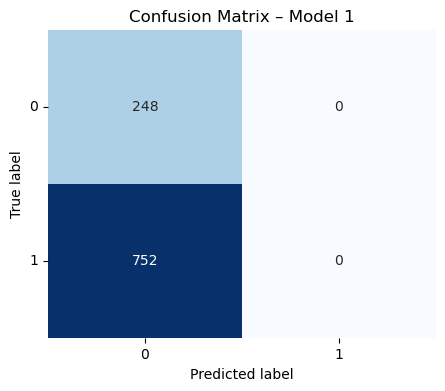

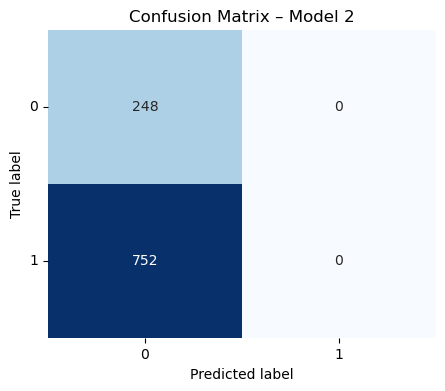

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix – {model_name}")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.xticks([0.5, 1.5], ["0", "1"])
    plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
    plt.show()

# Zbierz predykcje i prawdziwe etykiety dla obu modeli
for idx, model in enumerate([model1, model2], start=1):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(DEVICE), targets.squeeze().long().to(DEVICE)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    cm = confusion_matrix(all_targets, all_preds)
    plot_confusion_matrix(cm, f"Model {idx}")

Wnioski są jasne - modele 1 i 2 zawsze przewidują klasę 0 (prawdopodobnie faworyzują klasę większościową), co prowadzi do bardzo niskiej wartości BAC. Dodatkowo w przypadku zbioru walidacyjnego 3/4 etykiet to klasa 1 (prawdopodobnie klasa mniejszościowa).

### Eksploracja danych

Zaczynamy od analizy danych, aby lepiej zrozumieć ich strukturę i jakość. Wykonamy kilka podstawowych kroków EDA, takich jak:
- Sprawdzenie rozkładu klas w zbiorze treningowym
- Sprawdzenie jakości danych - czy są jakieś braki, błędy, niepoprawne etykiety
- Wizualizacja danych - np. histogramy, wykresy pudełkowe, aby zobaczyć rozkład wartości cech
- Analiza statystyczna (dla danych numerycznych) - obliczenie podstawowych statystyk, takich jak średnia, mediana, odchylenie standardowe, aby lepiej zrozumieć dane

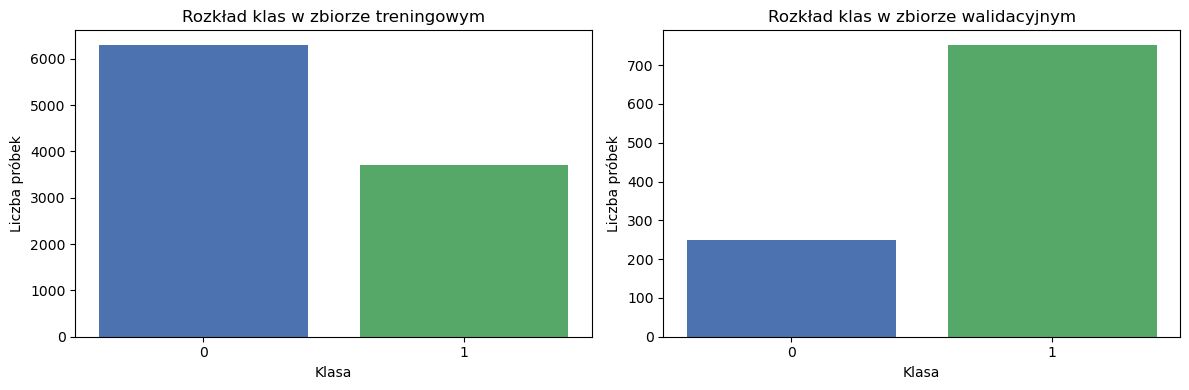

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# dystrybucja zbioru treningowego
train_targets = torch.cat([t.squeeze() for _, t in train_loader]).cpu().numpy()
axes[0].bar([0, 1], [(train_targets == 0).sum(), (train_targets == 1).sum()],
            color=['#4c72b0', '#55a868'])
axes[0].set_xticks([0, 1])
axes[0].set_title("Rozkład klas w zbiorze treningowym")
axes[0].set_xlabel("Klasa")
axes[0].set_ylabel("Liczba próbek")

# dystrybucja zbioru walidacyjnego
val_targets = torch.cat([t.squeeze() for _, t in val_loader]).cpu().numpy()
axes[1].bar([0, 1], [(val_targets == 0).sum(), (val_targets == 1).sum()],
            color=['#4c72b0', '#55a868'])
axes[1].set_xticks([0, 1])
axes[1].set_title("Rozkład klas w zbiorze walidacyjnym")
axes[1].set_xlabel("Klasa")
axes[1].set_ylabel("Liczba próbek")

plt.tight_layout()
plt.show()

Tutaj od razu widać, że mamy do czynienia z niezbalansowanym zbiorem danych. W zbiorze treningowym klasa 0 występuje znacznie częściej niż klasa 1. Natomiast, w zbiorze walidacyjnym mamy odwrotną sytuację - klasa 1 występuje znacznie częściej niż klasa 0. To może prowadzić do problemów z trenowaniem modelu, ponieważ model może nauczyć się faworyzować klasę większościową i ignorować klasę mniejszościową.

Braki w etykietach:
 Unnamed: 0    0
file_name     0
label         0
dtype: int64

Liczba próbek wg klasy:
 label
0    6298
1    3702
Name: count, dtype: int64

Brakujące pliki obrazów: 0


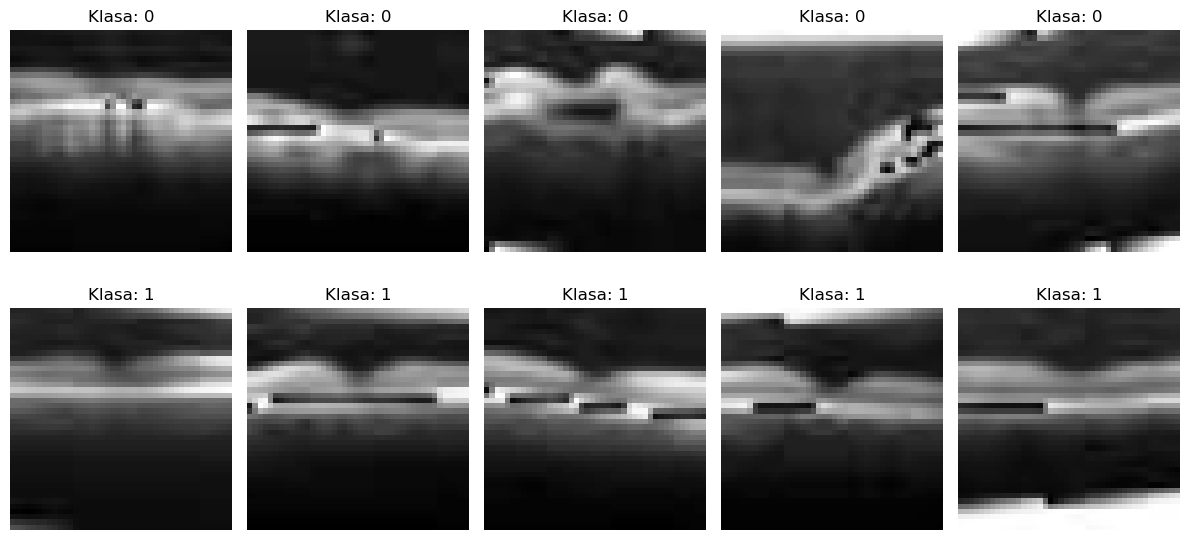

In [19]:
# Sprawdzenie braków i rozkładu etykiet
labels_df = train_loader.dataset.labels_df
print("Braki w etykietach:\n", labels_df.isnull().sum())
print("\nLiczba próbek wg klasy:\n", labels_df['label'].value_counts())

# Sprawdzenie, czy pliki obrazów istnieją
missing = [
    fn for fn in labels_df['file_name']
    if not os.path.exists(os.path.join(TRAIN_DATASET_PATH, IMAGES_DIR, fn))
]
print(f"\nBrakujące pliki obrazów: {len(missing)}")

# Wyświetlenie losowych próbek z każdej klasy
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for cls in [0, 1]:
    cls_samples = labels_df[labels_df['label'] == cls].sample(5, random_state=SEED)
    for i, (_, row) in enumerate(cls_samples.iterrows()):
        img = Image.open(os.path.join(TRAIN_DATASET_PATH, IMAGES_DIR, row['file_name']))
        ax = axes[cls, i]
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Klasa: {cls}")
        ax.axis('off')
plt.tight_layout()
plt.show()

W tym przypadku ciężko ocenić czy dane są błędnie etykietowane, ponieważ nie mamy wiedzy dziedzinowej. Jednak w niektórych przypadkach można wykorzystać wizualizacji, aby zobaczyć, jak dane są rozłożone w przestrzeni cech. Można również użyć technik takich jak PCA lub t-SNE, aby zredukować wymiarowość danych i zobaczyć, jak różne klasy są rozdzielone w przestrzeni cech.

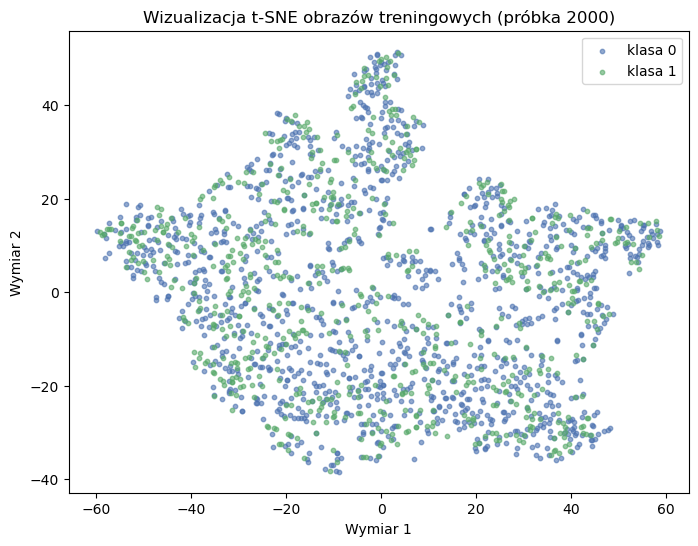

In [20]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

import matplotlib.pyplot as plt

# Krok 1: Ekstrakcja obrazów i etykiet.
imgs, lbls = [], []
for inputs, targets in train_loader:
    # Spłaszczenie obrazów i konwersja na NumPy array.
    b = inputs.view(inputs.size(0), -1).cpu().numpy()
    imgs.append(b)
    # Konwersja etykiet na NumPy array.
    lbls.append(targets.squeeze().cpu().numpy())

imgs = np.vstack(imgs)
lbls = np.concatenate(lbls)

# Inicjalizacja generatora liczb losowych.
rng = np.random.default_rng(SEED)

# Wybór losowej próbki 2000 obrazów.
sel = rng.choice(len(imgs), size=2000, replace=False)
X_sub, y_sub = imgs[sel], lbls[sel]

# Krok 2: Redukcja wymiarowości (PCA, a następnie t-SNE).
# PCA do wstępnej redukcji do 50 komponentów.
pca = PCA(n_components=50, random_state=SEED)
X_pca = pca.fit_transform(X_sub)

# t-SNE do redukcji do 2 wymiarów dla wizualizacji.
tsne = TSNE(n_components=2, random_state=SEED, init='pca', learning_rate='auto')
X_2d = tsne.fit_transform(X_pca)

# Krok 3: Wizualizacja danych 2D.
plt.figure(figsize=(8,6))
for cls, c in zip([0,1], ['#4c72b0','#55a868']):
    mask = y_sub == cls
    plt.scatter(X_2d[mask,0], X_2d[mask,1], s=10, c=c, label=f"klasa {cls}", alpha=0.6)
plt.legend()
plt.title("Wizualizacja t-SNE obrazów treningowych (próbka 2000)")
plt.xlabel("Wymiar 1")
plt.ylabel("Wymiar 2")
plt.show()


W tym przypadku nie widać jasno rozdzielenia klas, co może sugerować, że dane są trudne do klasyfikacji. Na podstawie wizualizacji nie możemy stwierdzić, czy dane są błędnie etykietowane, ponieważ nie widać ewidentnych wartości odstających.

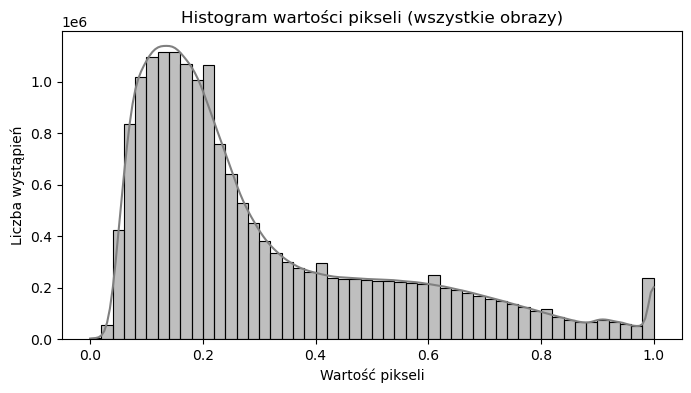

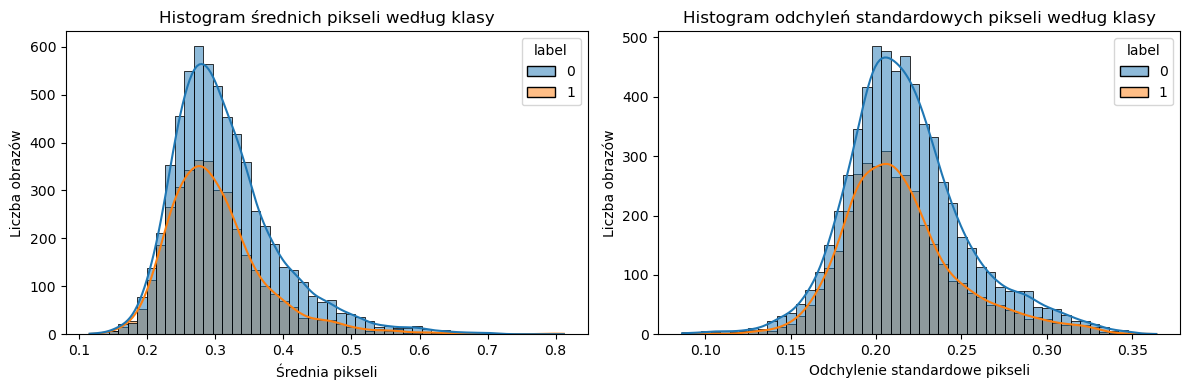

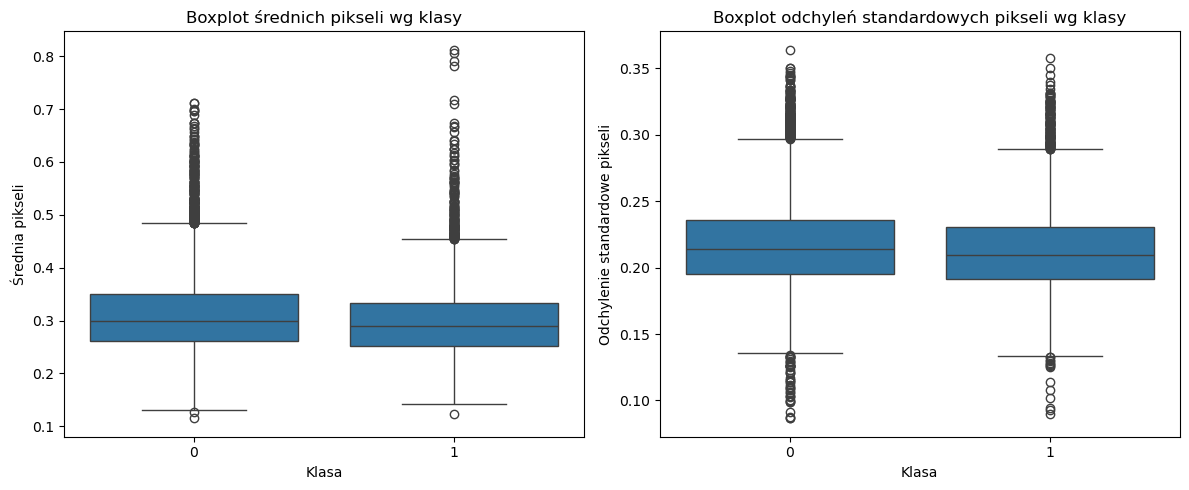

In [21]:
# Przygotowanie danych: spłaszczone obrazy i metryki per-obraz
pixel_values = imgs.flatten()
means = imgs.mean(axis=1)
stds = imgs.std(axis=1)
eda_df = pd.DataFrame({'mean': means, 'std': stds, 'label': lbls})

# Histogram rozkładu wartości pikseli w całym zbiorze
plt.figure(figsize=(8,4))
sns.histplot(pixel_values, bins=50, color='gray', kde=True)
plt.title("Histogram wartości pikseli (wszystkie obrazy)")
plt.xlabel("Wartość pikseli")
plt.ylabel("Liczba wystąpień")
plt.show()

# Histogramy średnich i odchyleń standardowych per klasa
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(eda_df, x='mean', hue='label', bins=50, kde=True)
plt.title("Histogram średnich pikseli według klasy")
plt.xlabel("Średnia pikseli")
plt.ylabel("Liczba obrazów")

plt.subplot(1,2,2)
sns.histplot(eda_df, x='std', hue='label', bins=50, kde=True)
plt.title("Histogram odchyleń standardowych pikseli według klasy")
plt.xlabel("Odchylenie standardowe pikseli")
plt.ylabel("Liczba obrazów")
plt.tight_layout()
plt.show()

# Boxploty średnich i odchyleń per klasa
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.boxplot(x='label', y='mean', data=eda_df, ax=axes[0])
axes[0].set_title("Boxplot średnich pikseli wg klasy")
axes[0].set_xlabel("Klasa")
axes[0].set_ylabel("Średnia pikseli")

sns.boxplot(x='label', y='std', data=eda_df, ax=axes[1])
axes[1].set_title("Boxplot odchyleń standardowych pikseli wg klasy")
axes[1].set_xlabel("Klasa")
axes[1].set_ylabel("Odchylenie standardowe pikseli")

plt.tight_layout()
plt.show()

Powyższe wykresy również pokazują, że wartości w obrazkach dla obu klas są zbliżone, co może sugerować, że dane są trudne do klasyfikacji.

### Eksperymentalne balansowanie danych

#### Podejście: **Wariacja Co-Teaching – Eksperymentowanie z Próbkowaniem na Podstawie Strat**

##### Cel:
Zrozumienie, jak różne strategie próbkowania (czyli ile procent przykładów z każdej klasy wybierać) wpływają na rozkład klas w zbiorze treningowym w kontekście metody inspirowanej **Co-Teachingiem** – techniką uczenia modeli odpornych na szum w etykietach.

#### Co to jest Co-Teaching?
W klasycznym Co-Teachingu:
- Dwa modele uczą się równolegle.
- Każdy wybiera próbki z najniższą stratą (czyli te, które uznaje za najbardziej wiarygodne).
- Następnie **wymieniają się** tymi próbkami – każdy trenuje na danych wybranych przez drugi model.

To pomaga unikać uczenia się na błędnych etykietach (szumie).

#### Co robi ten kod?

Ten kod **nie implementuje pełnego treningu Co-Teaching**, ale służy do **analizy, jak różne strategie próbkowania wpływają na rozkład wybranych próbek**. Jest to narzędzie do testowania i dostrajania strategii selekcji danych przed faktycznym treningiem modeli.

1. **Pobiera jedną partię danych** – obrazy i ich etykiety klasowe.
2. **Oblicza straty (loss) dla obu modeli** – ocenia trudność każdej próbki.
3. **Symuluje różne strategie próbkowania klas** – np. wybór 30% próbek z klasy 0 i 80% z klasy 1.
4. **Wybiera trudne próbki** – używając strat z jednego modelu do selekcji przykładów dla drugiego (cross-model selection).
5. **Zlicza i wizualizuje wyniki** – pokazuje, ile przykładów z każdej klasy zostało wybranych i jak wygląda rozkład dla każdej strategii.

Ten eksperyment pomaga dobrać **najlepsze proporcje próbkowania klas**. Celem jest znalezienie strategii, która:
- **filtruje zaszumione etykiety** (dzięki selekcji na podstawie strat),
- **balansuje dane** (poprzez dobór odpowiedniego udziału klas),
- **poprawia skuteczność trenowania modeli**, np. poprzez lepszy wynik BAC (Balanced Accuracy).


In [22]:
def test_sampling_rates(targets, losses, number_of_batches):
    # Pobierz dane do wizualizacji
    sample_targets = targets
    sample_losses1, sample_losses2 = losses
    
    # Policz próbki w każdej klasie
    class_counts = [np.sum(sample_targets == i) for i in range(NUM_CLASSES)]
    print(f"Rozkład klas w {number_of_batches} batchach: Klasa 0: {class_counts[0]}, Klasa 1: {class_counts[1]}")
    
    # Zdefiniuj strategie próbkowania do testów
    sampling_rates_to_test = [
        [0.3, 0.3],  # Równe niskie próbkowanie
        [0.8, 0.8],  # Równe wysokie próbkowanie
        [0.5, 0.5],  # Równe zbalansowane próbkowanie
        [0.3, 0.8],  # Więcej z klasy 1
        [0.8, 0.3],  # Więcej z klasy 0
        [0.5, 0.85],  # Wybrana strategia 1
        [0.5, 0.92]   # Wybrana strategia 2
    ]
    
    results = {}
    
    for rates in sampling_rates_to_test:
        selected_class0 = []
        selected_class1 = []
        
        for class_idx in range(NUM_CLASSES):
            class_mask = sample_targets == class_idx
            class_indices = np.where(class_mask)[0]
            take_n = int(len(class_indices) * rates[class_idx])
            
            # Użyj strat z przeciwnego modelu
            temp_losses = sample_losses2.copy()
            temp_losses[~class_mask] = float('inf')
            selected_indices = np.argsort(temp_losses)[:take_n]
            
            if class_idx == 0:
                selected_class0.extend(selected_indices)
            else:
                selected_class1.extend(selected_indices)
        
        total_selected = len(selected_class0) + len(selected_class1)
        results[f"Rates {rates}"] = {
            "class0_count": len(selected_class0),
            "class1_count": len(selected_class1),
            "total": total_selected,
            "class0_percent": len(selected_class0) / max(1, total_selected) * 100,
            "class1_percent": len(selected_class1) / max(1, total_selected) * 100
        }
    
    # Wyświetl wyniki
    for rate_name, stats in results.items():
        print(f"{rate_name}:")
        print(f"  Klasa 0: {stats['class0_count']} próbek ({stats['class0_percent']:.1f}%)")
        print(f"  Klasa 1: {stats['class1_count']} próbek ({stats['class1_percent']:.1f}%)")
        print(f"  Razem: {stats['total']} próbek")
        print()
    
    # Wizualizuj strategie próbkowania
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    rate_names = list(results.keys())
    x = np.arange(len(rate_names))
    
    plt.bar(x - bar_width/2, [results[r]["class0_percent"] for r in rate_names], 
            bar_width, label='Klasa 0')
    plt.bar(x + bar_width/2, [results[r]["class1_percent"] for r in rate_names], 
            bar_width, label='Klasa 1')
    
    plt.xlabel('Strategia próbkowania')
    plt.ylabel('Procent wybranych próbek')
    plt.title('Rozkład klas dla różnych strategii próbkowania')
    plt.xticks(x, [r.replace("Rates ", "") for r in rate_names], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

Rozkład klas w 10 batchach: Klasa 0: 830, Klasa 1: 450
Rates [0.3, 0.3]:
  Klasa 0: 249 próbek (64.8%)
  Klasa 1: 135 próbek (35.2%)
  Razem: 384 próbek

Rates [0.8, 0.8]:
  Klasa 0: 664 próbek (64.8%)
  Klasa 1: 360 próbek (35.2%)
  Razem: 1024 próbek

Rates [0.5, 0.5]:
  Klasa 0: 415 próbek (64.8%)
  Klasa 1: 225 próbek (35.2%)
  Razem: 640 próbek

Rates [0.3, 0.8]:
  Klasa 0: 249 próbek (40.9%)
  Klasa 1: 360 próbek (59.1%)
  Razem: 609 próbek

Rates [0.8, 0.3]:
  Klasa 0: 664 próbek (83.1%)
  Klasa 1: 135 próbek (16.9%)
  Razem: 799 próbek

Rates [0.5, 0.85]:
  Klasa 0: 415 próbek (52.1%)
  Klasa 1: 382 próbek (47.9%)
  Razem: 797 próbek

Rates [0.5, 0.92]:
  Klasa 0: 415 próbek (50.1%)
  Klasa 1: 414 próbek (49.9%)
  Razem: 829 próbek



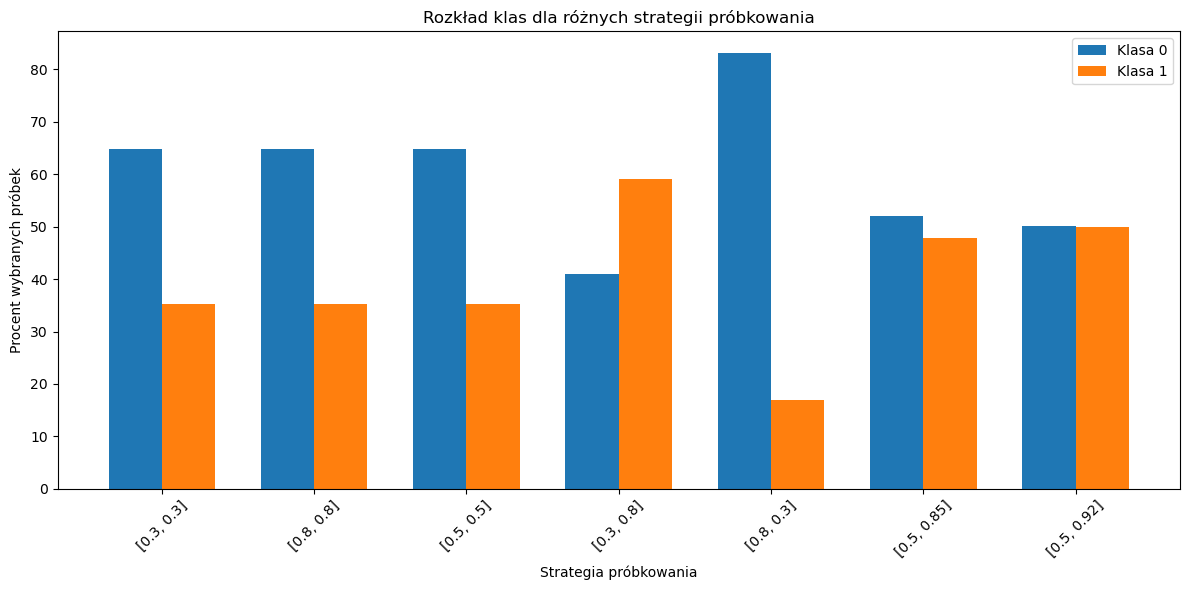

In [23]:
# Eksperymenty nie muszą wchodzić w skład ostatecznego rozwiązania
if not FINAL_EVALUATION_MODE:
    # Tworzymy akumulator, aby zebrać wyniki z 10 batchów
    number_of_batches = 10
    targets_acc, losses1_acc, losses2_acc = np.array([]), np.array([]), np.array([])
    for _ in range(min(number_of_batches, len(train_loader))):
        inputs, targets = next(iter(train_loader))
        inputs, targets = inputs.to(DEVICE), targets.squeeze().long().to(DEVICE)
        
        # Pobierz straty z obu modeli
        model1.eval()
        model2.eval()
        with torch.no_grad():
            outputs1 = model1(inputs)
            outputs2 = model2(inputs)
            
            loss1 = criterion(outputs1, targets)
            loss2 = criterion(outputs2, targets)
        
        targets_acc = np.concatenate((targets_acc, targets.cpu().numpy()), axis=0)
        losses1_acc = np.concatenate((losses1_acc, loss1.cpu().numpy()), axis=0)
        losses2_acc = np.concatenate((losses2_acc, loss2.cpu().numpy()), axis=0)
        
    test_sampling_rates(targets_acc, [losses1_acc, losses2_acc], number_of_batches)

Dla strategii [0.5, 0.92] prawie idealnie balansujemy klasy, ponieważ mamy 50% próbek z klasy 0 i 50% próbek z klasy 1. 

<h3 id="rozwiazanie"> Rozwiązanie </h3>

Ta funkcja wybiera najbardziej wiarygodne przykłady z partii danych (batcha), które zostaną użyte do trenowania dwóch modeli.

#### Jak to działa?

1. **Mamy dwa modele**, które oceniają każdą próbkę – przypisują jej tzw. stratę (im mniejsza, tym lepiej model ją rozumie).
2. **Każdy model wybiera dane dla drugiego modelu** – to pomaga unikać błędnych etykiet.
3. **Z każdej klasy (0 i 1) wybierana jest część danych** (na podstawie naszego eksperymentu):
   - 50% przykładów z klasy 0
   - 92% przykładów z klasy 1
4. **Wybierane są te przykłady, które drugi model uznał za najłatwiejsze** (najmniejsza strata).

Dzięki tej metodzie modele uczą się tylko na najbardziej zaufanych danych co pomaga lepiej trenować modele nawet wtedy, gdy niektóre etykiety są błędne (czyli mamy tzw. „szum w danych”).

In [24]:
def your_select_indices(
    targets: torch.Tensor, losses: List[torch.Tensor]
) -> List[torch.Tensor]:
    """
    Funkcja wybierająca indeksy zbioru treningowego do wykorzystania podczas trenowania modeli.

    Parametry:
        targets: Etykiety danych treningowych z danego batcha jako tensor. Wymiar: (batch_size,)
        losses: Dwuelementowa lista zawierająca tensory wartości funkcji straty dla poszczególnych modeli. Wymiar: [(batch_size,), (batch_size,)]

    Zwraca:
        Listę indeksów wybranych do aktualizacji wag modeli.
    """
    # Współczynniki próbkowania wybrany na podstawie eksperymentu
    take_n_by_class = [0.5, 0.92]
    # Inicjalizacja listy do przechowywania wybranych indeksów
    selected_indices = [[] for _ in range(2)]

    # Przetwarzanie klas osobno
    for class_idx in torch.unique(targets):
        # Wybór próbek dla bieżącej klasy
        class_mask = targets == class_idx
        class_indices = class_mask.nonzero(as_tuple=True)[0]
        take_n = int(len(class_indices) * take_n_by_class[class_idx])

        # Dla każdego modelu
        for i in range(2):
            # Selekcja krzyżowa - użyj strat z przeciwnego modelu
            t = losses[1 - i].clone().to(DEVICE)
            
            # Wybierz próbki o najniższej stracie tylko z bieżącej klasy
            t[targets.to(DEVICE) != class_idx] = float("Inf")
            _, best_idx = torch.topk(-t, k=take_n)
            
            # Dodaj wybrane indeksy do zbioru treningowego modelu
            selected_indices[i].extend(best_idx.cpu().tolist())

    return selected_indices

# Ewaluacja

Uruchomienie poniższych komórek pozwoli sprawdzić, ile punktów zdobyłoby Twoje rozwiązanie na danych walidacyjnych. Przed wysłaniem upewnij się, że cały notebook (również z ustawioną flagą `FINAL_EVALUATION_MODE = True`) wykonuje się od początku do końca bez błędów i bez konieczności ingerencji użytkownika po wybraniu opcji "Run All".


In [25]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
def final_evaluate(evaluate_data_path, model1, model2):

    base_transform = transforms.Compose([transforms.ToTensor()])
    evaluate_dataset = TaskDataset(root=evaluate_data_path, transform=base_transform)
    evaluate_loader = DataLoader(
        dataset=evaluate_dataset, batch_size=BATCH_SIZE, shuffle=False
    )

    bac_1 = predict_and_evaluate(model1, evaluate_loader, DEVICE, verbose=True)
    bac_2 = predict_and_evaluate(model2, evaluate_loader, DEVICE, verbose=True)
    return performance(bac_1, bac_2)

Epoch 1


Epoch 1/6:   0%|          | 0/79 [00:00<?, ?it/s]

Validation 1/6: 100%|██████████| 8/8 [00:00<00:00, 18.03it/s]


Model1 - Train Loss: 0.3792, Train balanced accuracy: 0.8164 --- Validation Loss: 1.0037, Validation balanced accuracy: 0.7732, 
Model2 - Train Loss: 0.3863, Train balanced accuracy: 0.8185 --- Validation Loss: 1.4518, Validation balanced accuracy: 0.6233, 
Epoch 2


Validation 2/6: 100%|██████████| 8/8 [00:00<00:00, 18.39it/s]


Model1 - Train Loss: 0.2612, Train balanced accuracy: 0.8739 --- Validation Loss: 0.4231, Validation balanced accuracy: 0.8647, 
Model2 - Train Loss: 0.2730, Train balanced accuracy: 0.8706 --- Validation Loss: 0.4019, Validation balanced accuracy: 0.8502, 
Epoch 3


Validation 3/6: 100%|██████████| 8/8 [00:00<00:00, 20.58it/s]


Model1 - Train Loss: 0.2214, Train balanced accuracy: 0.8832 --- Validation Loss: 0.9657, Validation balanced accuracy: 0.8377, 
Model2 - Train Loss: 0.2260, Train balanced accuracy: 0.8830 --- Validation Loss: 0.6905, Validation balanced accuracy: 0.8674, 
Epoch 4


Validation 4/6: 100%|██████████| 8/8 [00:00<00:00, 19.74it/s]


Model1 - Train Loss: 0.2022, Train balanced accuracy: 0.8993 --- Validation Loss: 0.5007, Validation balanced accuracy: 0.8707, 
Model2 - Train Loss: 0.2084, Train balanced accuracy: 0.8932 --- Validation Loss: 0.3079, Validation balanced accuracy: 0.8789, 
Epoch 5


Validation 5/6: 100%|██████████| 8/8 [00:00<00:00, 17.86it/s]


Model1 - Train Loss: 0.2078, Train balanced accuracy: 0.8907 --- Validation Loss: 0.2840, Validation balanced accuracy: 0.8910, 
Model2 - Train Loss: 0.2040, Train balanced accuracy: 0.8912 --- Validation Loss: 0.2702, Validation balanced accuracy: 0.8856, 
Epoch 6


Validation 6/6: 100%|██████████| 8/8 [00:00<00:00, 18.60it/s]


Model1 - Train Loss: 0.1882, Train balanced accuracy: 0.8985 --- Validation Loss: 0.7743, Validation balanced accuracy: 0.8490, 
Model2 - Train Loss: 0.1902, Train balanced accuracy: 0.8962 --- Validation Loss: 0.4862, Validation balanced accuracy: 0.8847, 


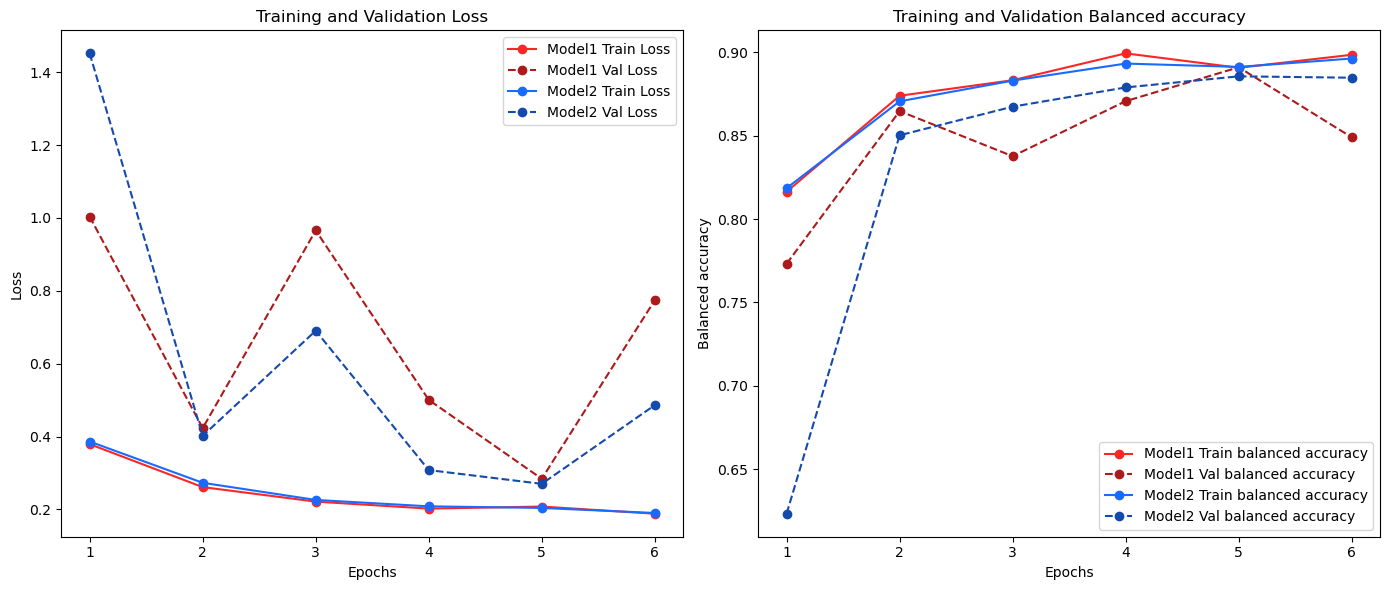

Balanced Accuracy: 0.8489833562113933
Balanced Accuracy: 0.8847160260809883
Twoje rozwiązanie ma średnią wartość balanced accuracy równą 0.86685 na zbiorze walidacyjnym, co daje 100/100 punktów.


In [26]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
if not FINAL_EVALUATION_MODE:
    seed_everything(SEED)
    criterion = nn.CrossEntropyLoss(reduction="none")

    model1 = SmallMobileNet(NUM_CLASSES).to(DEVICE)
    model2 = SmallMobileNet(NUM_CLASSES).to(DEVICE)

    optimizer1 = AdamW(model1.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    optimizer2 = AdamW(model2.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    seed_everything(SEED)
    train(
        model1,
        model2,
        optimizer1,
        optimizer2,
        criterion,
        train_loader,
        val_loader,
        NUM_EPOCHS,
        DEVICE,
        select_indices_fn=your_select_indices,
    )

    final_evaluate(VAL_DATASET_PATH, model1, model2)

Twoja funkcja `your_select_indices` zostanie zapisana do pliku `your_select_indices.pkl`, a następnie wykorzystana do trenowania modeli na zbiorze treningowym (zgodnie z powyższym kodem). Finalna liczba punktów zostanie wyliczona na podstawie jakości klasyfikacji na zbiorze testowym.

In [27]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
if FINAL_EVALUATION_MODE:
    import cloudpickle

    OUTPUT_PATH = "file_output"
    FUNCTION_FILENAME = "your_select_indices.pkl"
    FUNCTION_OUTPUT_PATH = os.path.join(OUTPUT_PATH, FUNCTION_FILENAME)

    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)

    with open(FUNCTION_OUTPUT_PATH, "wb") as f:
        cloudpickle.dump(your_select_indices, f)